# Liver Segmentation with UNet architecture

### In this notebook, we'll load a pretrained UNet model and predict on test images.
#### Training code at the end of the notebook lets you train your own UNet model

First, the needed imports.

In [21]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import SimpleITK as sitk
import scipy.misc as misc
import scipy.ndimage as snd
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import h5py
%matplotlib inline
import progressbar

## Utility Functions:

#### display_image_label_and_output:
    A matplotlib function to plot the image, its label and the corresponding output from the network

In [22]:
def display_image_label_and_output(image, label, output):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(image, cmap = 'gray')
    plt.subplot(1,3,2)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.subplot(1,3,3)
    plt.imshow(output, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.show()    

#### predict_on_test_data:
    given the model and the number of files, we predict on those and display the outputs using the above function

In [23]:
def predict_on_test_data(model, n_files = 20):
    test_files = os.listdir('/home/ryan/stark/Medical_ImageSegmentation_UNET/data/test_images')
    test_imgs = [os.path.join('test_images',f) for f in test_files if 'img' in f][:n_files]
    test_labels = [f.replace('img', 'label') for f in test_imgs][:n_files]
    for f,g in zip(test_imgs, test_labels):
        img_arr = imageio.imread(f)
        img_arr = (np.float32(img_arr) - img_arr.min())/(img_arr.max() - img_arr.min())
        label_arr = imageio.imread(g)
        label_arr = np.uint8((label_arr - label_arr.min())/(label_arr.max() - label_arr.min()))
        # input to neural net has to be of form NCWH
        inputs = img_arr[None,None,:,:]
        inputs = Variable(torch.from_numpy(inputs), volatile = True)
        outs = model.forward(inputs)
        _, outs = torch.max(outs, 1)
        output_arr = outs.data.numpy()[0]
        display_image_label_and_output(img_arr, label_arr, output_arr)

In [24]:
def predict(model, image) :
    image

## UNet Network architecture

### nn.Sequential
    A sequential container. Modules will be added to it in the order they are passed in the constructor

### nn.Conv2d

    Applies a 2D convolution over an input signal composed of several input planes.
    stride controls the stride for the cross-correlation, a single number or a tuple.
    padding controls the amount of implicit zero-paddings on both sides for padding number of points for each dimension.
    dilation controls the spacing between the kernel points; also known as the à trous algorithm.

In [25]:
class UNet(nn.Module):
    
    def __init__(self):
        
        super(UNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        
        self.upconv1 = nn.Sequential(nn.ConvTranspose2d(128,128,stride=2, kernel_size=2), nn.BatchNorm2d(128))
        self.conv5 = nn.Sequential(nn.Conv2d(128,64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.upconv2 = nn.Sequential(nn.ConvTranspose2d(128,32,stride=2, kernel_size=2), nn.BatchNorm2d(32))
        self.conv6 = nn.Sequential(nn.Conv2d(32,2, kernel_size=3, padding=1), nn.BatchNorm2d(2))
        
    def forward(self, x):
        
        x = F.relu(self.conv2(F.relu(self.conv1(x))), inplace=True)
        x_0 = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv4(F.relu(self.conv3(x_0))), inplace=True)
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(F.relu(self.upconv1(x))))
        x = torch.cat([x,x_0], 1)
        x = self.conv6(F.relu(self.upconv2(x)))
        x = F.log_softmax(x, dim=1)
        
        return x

## Network with random weights

In [26]:
model = UNet()
print(model)
predict_on_test_data(model, n_files = 5)

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2

FileNotFoundError: No such file: '/home/ryan/stark/Medical_ImageSegmentation_UNET/test_images/img11.png'

## Network loaded with trained weights

In [27]:
state = torch.load('/home/ryan/stark/Medical_ImageSegmentation_UNET/data/pertained_models/u-net_cpu.tar')['state_dict']
model = UNet()
model.load_state_dict(state)
#predict_on_test_data(model, n_files = 1)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Training Code (Take Home)
Additional requirements : GPU | Additional dependencies : progressbar

In [28]:
class SimpleTrainer(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
    def forward_backward(inputs, labels):
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs).cuda()
        labels = Variable(labels).cuda()
        self.optimizer.zero_grad()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.data[0]

    def forward(inputs, labels):
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        return loss.data[0]

## Prepare training data

The 2D slices are saved in .h5 format (H5 file is a data file saved in the Hierarchical Data Format (HDF). It contains multidimensional arrays of scientific data.)
Images and labels are stored as two datasets in the h5 file and can be accessed by file_obj\['image'\] and file_obj\['label'\]

We get the images and labels from it, randomise it and split it for training and validation.

In [29]:
def get_training_data():
    # Reading the .h5
    x = h5py.File('/home/ryan/stark/Medical_ImageSegmentation_UNET/data/2qDLiverSlices_128.h5','r')
    
    # Getting the images and the labels
    images = x['image'][:]
    labels = x['label'][:]
    x.close()
    
    randperm = np.random.permutation(images.shape[0])
    images = images[randperm]
    labels = labels[randperm]
    
    # Splitting the data into training and validation
    train_images = images[:1500]
    train_labels = labels[:1500]
    val_images = images[1500:]
    val_labels = labels[1500:]    
    return train_images, train_labels, val_images, val_labels

### Defining the hyper-parameter for the network

In [30]:
EPOCHS = 100  # Number of iterations for training the newtork
BATCH_SIZE = 48  # Number of training example to be fed to the network
PATCH_SIZE = [128,128]  # the input size of the image (L*B)

## Initialize the model

## Optimization:
Use the optim package to define an Optimizer that will update the weights of the model for us.

In [31]:
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=5e-5)
trainer = SimpleTrainer(model,nn.NLLLoss2d(), optimizer)
train_images, train_labels, val_images, val_labels = get_training_data()

In [39]:
for i in range(EPOCHS):
    print('Epoch: ' + str(i))
    
    # train
    model.train()
    train_loss = []
    bar = progressbar.ProgressBar()
    for j in bar(range(0, train_images.shape[0], BATCH_SIZE)):
        
        image_batch, label_batch = train_images[j: j+BATCH_SIZE], train_labels[j: j+BATCH_SIZE]
        image_batch = image_batch.reshape(image_batch.shape[0], 1, PATCH_SIZE[0], PATCH_SIZE[1])
        train_loss.append(trainer.forward_backward(image_batch, label_batch))
    print('Train loss: ' + str(np.array(train_loss).mean()))
    
    torch.save({'state_dict':model.cpu().float().state_dict()}, 'conv-deconv_cpu.tar')
    model.cuda()
    # validate
    
    model.eval()    
    val_loss = []
    bar = progressbar.ProgressBar()
    for j in bar(range(0, val_images.shape[0], BATCH_SIZE)):
        image_batch, label_batch = val_images[j: j+BATCH_SIZE], val_labels[j: j+BATCH_SIZE]
        image_batch = image_batch.reshape(image_batch.shape[0], 1, PATCH_SIZE[0], PATCH_SIZE[1])
        val_loss.append(trainer.forward(image_batch, label_batch))
    print('Val loss: ' + str(np.array(val_loss).mean()))

Epoch: 0


TypeError: expected np.ndarray (got SimpleTrainer)

### Show results on validation data

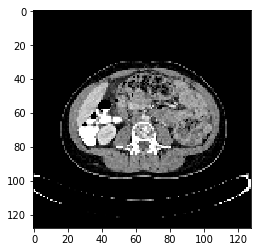

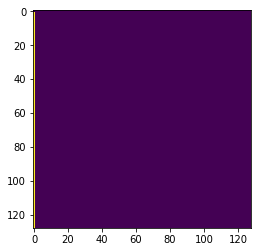

In [33]:
model.eval()
inputs = Variable(torch.from_numpy(val_images[3].reshape(1,1,128,128))).cuda()
out = model.forward(inputs)
out = np.argmax(out.data.cpu().numpy(), axis=1).reshape(128,128)
plt.figure()
plt.imshow(val_images[3], cmap = 'gray')
plt.figure()
plt.imshow(out)